In [1]:
from udma import UDMA_CLASS as udma
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
from nistrng import *

In [2]:
#Load Comblock
cb=udma("192.168.1.10", 7)
cb.connect()
cb.log(0)

[(5,), 0]

In [3]:
# Write init values in fifo:
## Clean output fifo
cb.write_reg(37 -16, 1) 
cb.write_reg(37 -16, 0)

## Loading initial values into fifo_out
fifo_init=np.array(range(1000))
# fifo_init=np.full(1000,0)
print(cb.write_fifo(len(fifo_init),fifo_init))

## Enable load values
cb.write_reg(4, 1)
sleep(1)
cb.write_reg(4,0)

[(1, 1000), 0]


[(1, 0), 0]

In [4]:
def config(rule=2845481637, fb=6, div=20, xor_en=0):
    cb.write_reg(9, 0) #Test disable
    cb.write_reg(6, 0) #Stop FIFO
    cb.write_reg(5,1) #Stop (Reset) caa
    cb.write_reg(8, rule) #Set rule
    cb.write_reg(0,fb) #Set feedback type
    cb.write_reg(1,0) #Set to asynchronous
    cb.write_reg(2,0) #Change 'clear' value to 0
    cb.write_reg(3,0) #Change 'set' value to 0

    #Reset cell array
    cb.write_reg(5,1)
    cb.write_reg(5,0)

    #Disable fifo write
    cb.write_reg(6,0)

    #Select xor mode 1 to xor output, 0 to raw data.
    cb.write_reg(12, xor_en)

    #Setting clock divider
    cb.write_reg(10, div)
    cb.write_reg(11, 1)
    cb.write_reg(11, 0)

    #Clear fifo input
    cb.write_reg(33 - 16, 1) 
    cb.write_reg(33 - 16, 0)

In [8]:
#Set up automatas
# config(rule=2845481637, fb=6, div=100, xor_en=0)
config(rule=1771476585, fb=5, div=2, xor_en=1)

#Check if FIFO is empty
print(cb.read_reg(34)[1][0]>>16)
#Read fifo
N=int(50000)
b=cb.write_reg(6,1)
sleep(5)
data=[]
while len(data)<N:
    a=cb.read_fifo(1000)
    data.extend(a[1])
cb.write_reg(6,0)

0


[(1, 0), 0]

[0 1 1 ... 1 1 0]


(array([800627.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 799373.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

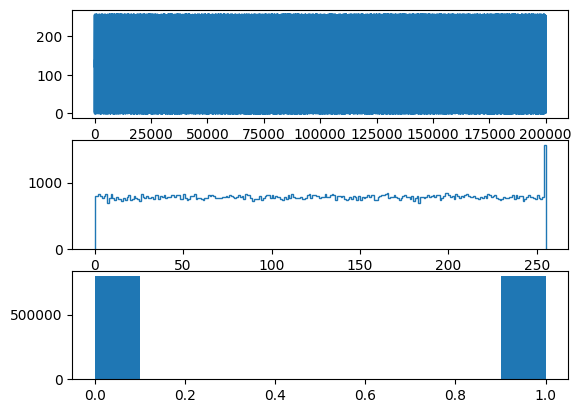

In [9]:
dsplit=[]
for d in data:
    dsplit.append(d&0xff)
    dsplit.append((d>>8)&0xff)
    dsplit.append((d>>16)&0xff)
    dsplit.append((d>>24)&0xff)

sequence: np.ndarray = np.array(dsplit).astype(np.uint8)

fig, ax=plt.subplots(3)
ax[0].plot(sequence)

counts, bins=np.histogram(sequence, 0xff)

ax[1].stairs(counts, bins)
#Packing sequence and checking balance
binary_sequence: np.ndarray = pack_sequence(sequence)
print(binary_sequence)
ax[2].hist(binary_sequence)

In [6]:
seq1=sequence[:int(len(sequence)/2)]
seq2=np.bitwise_not(sequence[int(len(sequence)/2):])
sequence=seq1+seq2
fig, ax=plt.subplots(3)
ax[0].plot(sequence)

counts, bins=np.histogram(sequence, 0xff)

ax[1].stairs(counts, bins)
#Packing sequence and checking balance
binary_sequence: np.ndarray = pack_sequence(sequence)
print(binary_sequence)
ax[2].hist(binary_sequence)


NameError: name 'sequence' is not defined

In [ ]:
def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n-1) + fibonacci(n-2)
    
def fib(n):
    res=[]
    for i in range(n):
        res.append(fibonacci(i))
    return res

mask_bits=np.array(fib(int(32/2)))%32

mask=0
for i in mask_bits:
    mask=np.bitwise_xor(mask,(2**i))

hex(mask)

In [ ]:
np.bitwise_xor(1,5)

In [ ]:
dsplit=[]
data_mask=np.bitwise_xor(np.array(data), mask)
for d in data_mask:
    dsplit.append(d&0xff)
    dsplit.append((d>>8)&0xff)
    dsplit.append((d>>16)&0xff)
    dsplit.append((d>>24)&0xff)

sequence: np.ndarray = np.array(dsplit).astype(np.int8)

fig, ax=plt.subplots(3)
ax[0].plot(sequence)

counts, bins=np.histogram(sequence, 0xff)

ax[1].stairs(counts, bins)
#Packing sequence and checking balance
binary_sequence: np.ndarray = pack_sequence(sequence)
print(binary_sequence)
ax[2].hist(binary_sequence)

In [10]:
# Random number generated sequence
# sequence: np.ndarray = np.random.randint(-128, 128, 1000, dtype=int)

# Packing sequence into binary
# binary_sequence: np.ndarray = pack_sequence(sequence)
# Print sequence
print("CAA Generated sequence generated by np:")
print(sequence)
print("Random sequence generated by np encoded in 8-bit signed format:")
print(binary_sequence)
print("Original sequence taken back by unpacking (to check the correctness of packing process:")
print(unpack_sequence(binary_sequence))
# Check the eligibility of the test and generate an eligible battery from the default NIST-sp800-22r1a battery
eligible_battery: dict = check_eligibility_all_battery(binary_sequence, SP800_22R1A_BATTERY)
# Print the eligible tests
print("Eligible test from NIST-SP800-22r1a:")
for name in eligible_battery.keys():
    print("-" + name)
# Test the sequence on the eligible tests
results = run_all_battery(binary_sequence, eligible_battery, False)
# Print results one by one
print("Test results:")
for result, elapsed_time in results:
    if result.passed:
        print("- PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
    else:
        print("- FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

CAA Generated sequence generated by np:
[121 255  83 ... 187 102 190]
Random sequence generated by np encoded in 8-bit signed format:
[0 1 1 ... 1 1 0]
Original sequence taken back by unpacking (to check the correctness of packing process:
[121  -1  83 ... -69 102 -66]
Eligible test from NIST-SP800-22r1a:
-monobit
-frequency_within_block
-runs
-longest_run_ones_in_a_block
-binary_matrix_rank
-dft
-non_overlapping_template_matching
-overlapping_template_matching
-maurers_universal
-linear_complexity
-serial
-approximate_entropy
-cumulative sums
-random_excursion
-random_excursion_variant
Test results:
- PASSED - score: 0.322 - Monobit - elapsed time: 0 ms
- PASSED - score: 0.92 - Frequency Within Block - elapsed time: 0 ms
- PASSED - score: 0.574 - Runs - elapsed time: 209 ms
- PASSED - score: 0.956 - Longest Run Ones In A Block - elapsed time: 699 ms
- PASSED - score: 0.625 - Binary Matrix Rank - elapsed time: 5034 ms
- FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 5